# Introduction

In this notebook, I am going to build a model and generate predictions for the (DonorsChoose.org Application Screening Kaggle competition)[https://www.kaggle.com/c/donorschoose-application-screening].

For the sake of brevity, I will concentrate on using 2 particular machine learning algorithms - one for the text features and another for the structured data. I have settled on XGBoost for the former because it tends to perform well on structured data, which we have here, and I want to gain more experience using it. I will use Multinomial Naive Bayes for the text features for simplicity. I have resisted the temptation to over-optimise and focus rather on getting a proof of concept that could be built on further.

I ended up achieving an AUC of 0.75409, without doing any parameter tuning or playing around very much with feature engineering. Doing this, as well as being more flexible with my modelling approach (trying different models and specifications) would likely see some improvement. I didn't enter this competition for the competition but for the experience. However, a comparison to the leaderboard provides some context for the model perforance. I submitted my final result after the competition ended but I would have placed 317 out of 581. It's not too bad, considering I didn't do any tuning. Also the top score was 0.83307, which is not *too* far from my score. In a real-world setting, this could be good enough to try out in the field while iterating on it and gathering feedback.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_predict

sys.path.append('../src/custom-modules')
from model_diagnostics import classification_model_cv_results, classification_model_holdout_results
from utilities import *

/Users/jonathan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')
resources = pd.read_csv('../data/raw/resources.csv')

/Users/jonathan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Initial Exploration & Wrangling

First, I'm going to deal with the `train` dataset. Let's convert `project_submitted_datetime` to datetime off the bat. The other columns seem correctly formatted.

In [3]:
train['project_submitted_datetime'] = pd.to_datetime(train['project_submitted_datetime'])
train.dtypes

id                                                      object
teacher_id                                              object
teacher_prefix                                          object
school_state                                            object
project_submitted_datetime                      datetime64[ns]
project_grade_category                                  object
project_subject_categories                              object
project_subject_subcategories                           object
project_title                                           object
project_essay_1                                         object
project_essay_2                                         object
project_essay_3                                         object
project_essay_4                                         object
project_resource_summary                                object
teacher_number_of_previously_posted_projects             int64
project_is_approved                                    

Next, let's look for missing data. There are only 3 columns with missing data. 

In [4]:
missing_values = train.isnull().sum()
missing_values[missing_values>0]

teacher_prefix          4
project_essay_3    175706
project_essay_4    175706
dtype: int64

We expect for all data for `project_essay_3` and `project_essay_4` to be missing since they were removed from May 17, 2016. We can see this in the dataset and no missing values for these columns thereafter.

In [5]:
print('Before 2016-05-17:\n')
print(train.loc[train['project_submitted_datetime'] <= '2016-05-17', ['project_essay_3', 'project_essay_4']].info())
print('\nAfter 2016-05-17:\n')
print(train.loc[train['project_submitted_datetime'] > '2016-05-18', ['project_essay_3', 'project_essay_4']].info())

Before 2016-05-17:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6345 entries, 18 to 182079
Data columns (total 2 columns):
project_essay_3    6345 non-null object
project_essay_4    6345 non-null object
dtypes: object(2)
memory usage: 148.7+ KB
None

After 2016-05-17:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175436 entries, 0 to 182078
Data columns (total 2 columns):
project_essay_3    0 non-null object
project_essay_4    0 non-null object
dtypes: object(2)
memory usage: 4.0+ MB
None


There are only 4 missing values for `teacher_prefix` so I'm going to set them to 'MISSING'

In [6]:
train['teacher_prefix'] = train['teacher_prefix'].fillna('MISSING')

Let's take a peak at the numerical data. We can see that about 85% of the projects are actually approved. This is quite an unbalanced dataset. The metric that we will be using to validate the model, AUC, is unaffected by class imbalance but dealing with it may improve the performance of our model. I tried oversampling the minory class but it didn't make a difference in my case. But perhaps other methods (such as creating a synthetic sample) could produce more fruitful results. 

Something else that's noticable is the maximum of `teacher_number_of_previously_posted_projects`. Although it has a median of 2 and an upper quartile of 9, the max is an impressive 451.

In [7]:
print(train.describe())

       teacher_number_of_previously_posted_projects  project_is_approved
count                                 182080.000000        182080.000000
mean                                      11.237055             0.847682
std                                       28.016086             0.359330
min                                        0.000000             0.000000
25%                                        0.000000             1.000000
50%                                        2.000000             1.000000
75%                                        9.000000             1.000000
max                                      451.000000             1.000000


As the tutorial kernal [Getting Started with the DonorsChoose Data Set
](https://www.kaggle.com/skleinfeld/getting-started-with-the-donorschoose-data-set) suggests, if we plot `teacher_number_of_previously_posted_projects` with a bin size of 10, we can see that this variable has a very long tail. The fact that it's uniformly distributed after 10 suggets that it's large values shouldn't be treated as outliers.

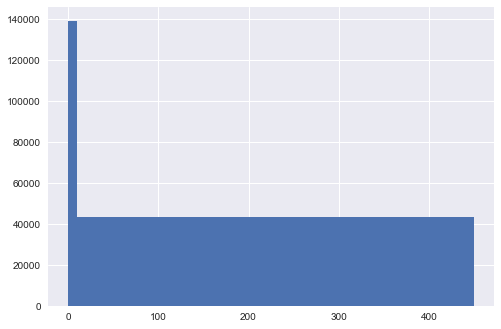

In [8]:
train['teacher_number_of_previously_posted_projects'].hist(bins=[0,10,450]);

Let's look at the counts for categorical data. We can see that the data is quite clean.

In [9]:
# Find the categorical columns
categorical_cols = ['teacher_prefix', 'school_state', 'project_grade_category', 'project_subject_categories', 
                    'project_subject_subcategories']

for c in categorical_cols:
    print('\n{0}\n'.format(c))
    print(train[c].value_counts())
    print(train.groupby(c)['project_is_approved'].mean())


teacher_prefix

Mrs.       95405
Ms.        65066
Mr.        17667
Teacher     3912
Dr.           26
MISSING        4
Name: teacher_prefix, dtype: int64
teacher_prefix
Dr.        0.807692
MISSING    1.000000
Mr.        0.842022
Mrs.       0.854085
Ms.        0.843052
Teacher    0.794223
Name: project_is_approved, dtype: float64

school_state

CA    25695
TX    12304
NY    12157
FL    10359
NC     8463
IL     7332
GA     6636
SC     6463
MI     5324
PA     5093
IN     4314
MO     4247
OH     4139
MA     4054
LA     3946
WA     3903
OK     3829
NJ     3671
AZ     3614
VA     3446
WI     2983
AL     2955
TN     2836
UT     2814
CT     2766
MD     2480
NV     2297
MS     2222
KY     2172
OR     2119
MN     2055
CO     1887
AR     1757
ID     1113
IA     1079
KS     1060
NM      916
DC      902
HI      869
WV      839
ME      827
DE      589
NH      587
AK      557
SD      494
NE      493
RI      475
MT      384
ND      248
WY      177
VT      139
Name: school_state, dtype: int64
school_st

Let's now check for duplicated data. First I'll check for duplicated rows (i.e. all the columns in one row are the same as all of the columns in another). I'll drop a few columns, such as `id`, which we could expect to be different even if all the other columns cause a row to be a duplicate. 

If we exclude `project_is_approved`, we can see that there are 28 duplicate rows.

In [10]:
print('\nConsistent - `project_is_approved` is also duplicated\n')
check_for_dupes = train.drop(['id', 'project_submitted_datetime',
                                     'teacher_number_of_previously_posted_projects'], axis=1)
print(check_for_dupes.duplicated().value_counts())

print('\nInconsistent: `project_is_approved` is NOT duplicated\n')
check_for_dupes = train.drop(['id', 'project_submitted_datetime',
                                     'teacher_number_of_previously_posted_projects',
                                    'project_is_approved'], axis=1)
print(check_for_dupes.duplicated().value_counts())


Consistent - `project_is_approved` is also duplicated

False    182057
True         23
dtype: int64

Inconsistent: `project_is_approved` is NOT duplicated

False    182052
True         28
dtype: int64


For now, I'm just going to delete all of these duplicates, since they may bias the results down the line and there are so few of them.

In [11]:
train = train.loc[~train.duplicated(keep=False)]

In addition to these, we would expect the `project_essay` columns to be unique but here we actually do find some duplicates. 

In [12]:
cols = ['project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4']
for c in cols:
    print('\n{0}\n'.format(c))
    print(train[c].dropna().duplicated().value_counts())


project_title

False    164282
True      17798
Name: project_title, dtype: int64

project_essay_1

False    147689
True      34391
Name: project_essay_1, dtype: int64

project_essay_2

False    180984
True       1096
Name: project_essay_2, dtype: int64

project_essay_3

False    6359
True       15
Name: project_essay_3, dtype: int64

project_essay_4

False    6336
True       38
Name: project_essay_4, dtype: int64


It's not clear what to do with these duplicates. In some cases, the `project_subject_categories` might be different even though the essays are the same. Is this ok? I'm going to keep the duplicates in here for now and put a pin in this - later, I could try to remove the duplicates somehow and see if that improves the model performance.

Now let's look at the resources data. We can see that there are a few missing descriptions.

In [13]:
missing_values = resources.isnull().sum()
missing_values[missing_values>0]

description    292
dtype: int64

For these, let's just substitute 'MISSING', since the fact that there the values are missing could be predictive of not being approved.

In [14]:
resources['description'] = resources['description'].fillna('MISSING')

One thing that looks noteworthy with respect to the numbers is that the minimum price is zero. This is unusual and may reflect incorrect data. I'll leave it for now though.

In [15]:
print(resources.describe())

           quantity         price
count  1.541272e+06  1.541272e+06
mean   2.860509e+00  5.028398e+01
std    7.570345e+00  1.447326e+02
min    1.000000e+00  0.000000e+00
25%    1.000000e+00  7.900000e+00
50%    1.000000e+00  1.499000e+01
75%    2.000000e+00  3.980000e+01
max    8.000000e+02  9.999000e+03


# Feature Engineering & Further Exploration

I am now going to construct some features from the data and perform some additional exploration based on that. I'll proceed in 3 parts:
1. Deal with `resources` dataset
2. Deal with `train` dataset
3. Combined datasets

#### 1. Deal with the resources dataset

We're told in the data description that many projects will require multiple resources. So the project id (`id`) will be duplicated. I'm going to collape all the data related to a project into a single line to make things easier to work with. For the `description`, I'll just append the words. For the `quantity` and `price`, I'll just find the means. I'll also work out how many resources were requested for each project.

In [16]:
resources['total_price'] = resources['price'] * resources['quantity']

collapsed_resources = resources.pivot_table(index = ['id'],
                                            aggfunc = {'description': [lambda x: x.tolist(), 'count'],
                                                       'total_price': ['sum', 'mean', 'max']})
collapsed_resources = collapsed_resources.reset_index()

# Break multi-level column names into individual lists
header_0 = [h[0] for h in collapsed_resources.columns]
header_1 = [h[1] for h in collapsed_resources.columns]
col_names = list(map('_'.join, zip(header_0, header_1)))

collapsed_resources.columns = col_names
collapsed_resources = collapsed_resources.rename(columns = {'id_': 'id', 'description_<lambda>': 'resource_descriptions', 'description_count': 'resources_count'})
# Get one string combining all descriptions separated by ' ; '
collapsed_resources['resource_descriptions'] = collapsed_resources['resource_descriptions'].apply(lambda x: ' ; '.join(map(str, x)))

collapsed_resources.head()

,id,resource_descriptions,resources_count,total_price_max,total_price_mean,total_price_sum
0,p000001,"Cap Barbell 300 Pound Olympic Set, Grey ; Cap ...",4,522.16,208.407500,833.63
1,p000002,10 Sony Headphones (BUY 9 GET 1 FREE) ; Belkin...,14,134.90,45.020000,630.28
2,p000003,EE820X - Phonemic Awareness Instant Learning C...,4,169.00,74.742500,298.97
3,p000004,A Bad Case of the Giggles Poems That Will Make...,95,401.54,11.854947,1126.22
4,p000005,"Fitbit Zip Wireless Activity Tracker, Lime ; F...",4,323.75,175.577500,702.31


#### 2. Deal with the train dataset

Get word_counts for title and essays. Since the format changed on 17 May 2016, I'll get word-counts for each essay before and after this date, respectively.

In [17]:
train['after_20160517'] = np.where(train['project_submitted_datetime'] > '2016-05-17', 1, 0)

for i, period in enumerate(['before', 'after']):
    for col in ['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4']:
        wordcount_colname = '{0}_wordcount_{1}'.format(col, period)
        train.loc[train['after_20160517']==i, 
                  wordcount_colname] = (train
                                        .loc[train['after_20160517']==i, col]
                                        .apply(lambda x: len(str(x).split(' '))))
        train[wordcount_colname] = train[wordcount_colname].fillna(0)  # Will get null values where there are no words. Fill these with zero.
        
train['project_title_wordcount'] = (train['project_title'].apply(lambda x: len(str(x).split(' '))))
train['project_title_wordcount'] = train['project_title_wordcount'].fillna(0)  # Will get null values where there are no words. Fill these with zero.

Extract date from `project_submitted_datetime`.

In [18]:
train['date'] = train['project_submitted_datetime'].dt.date

#### 3. Join the datasets together by id

In [19]:
train = train.merge(collapsed_resources, how='inner', on='id', copy=False)

# Build the model

Split `train` data into training and testing sets for internal validation.

In [20]:
training, testing = train_test_split(train, stratify=train['project_is_approved'], random_state=0)

I tried a few different approaches but the one that I settled on, which gave the best performance given the parameter space, was a stacked model approach:
1. Predict probabilities using text features alone
2. Predict probabilities using non-text features
3. Combine non-text features with predicted probabilities from (1) and (2) above for a final prediction

The categories for one project can combine terms that are common to categories in other projects, but in different orders or combinations take "Math & Science, Literacy & Language" and "Literacy & Language, Math & Science" for instance. If we treat each of these subjects as seperate, or fail to identify the commonalities in them, we might lose relevant information and therefore increase the model bias. Simimlarly for subcategories. I'm going to therefore extract the individual terms using a bag-of-words approach and use those as features in the model.

Use Multinomial Naive Bayes model to predict probabilities based on text features.

In [21]:
# ====================================
# Make predictions using text features
# ====================================

ctv = CountVectorizer(analyzer='word', ngram_range=(1, 3), stop_words = 'english', min_df=0.025)
mnb = MultinomialNB()

# Handle the essays (to deal with the different formats)
for i, period in enumerate(['before', 'after']):
    for col in ['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4']:
        predict_text(training, 
                     testing, 
                     col, 
                     ctv, 
                     mnb, 
                     training['after_20160517']==i, 
                     testing['after_20160517']==i, 
                     df_filter_desc=period,
                     show_model_results=True, 
                     fit_model=True)

# Handle the text features other than the essays
for col in ['project_title', 'resource_descriptions']:
    predict_text(
        training, 
        testing, 
        col, 
        ctv, 
        mnb, 
        show_model_results=True, 
        fit_model=True)

project_essay_1 - before:
Area under ROC: 0.511986221664
project_essay_2 - before:
Area under ROC: 0.529566401341
project_essay_3 - before:
Area under ROC: 0.630680460519
project_essay_4 - before:
Area under ROC: 0.562849695108
project_essay_1 - after:
Area under ROC: 0.562653123377
project_essay_2 - after:
Area under ROC: 0.678271136375
project_title - :
Area under ROC: 0.527995611776
resource_descriptions - :
Area under ROC: 0.612433225988


Fit xgb model using non-text features

In [ ]:
xgb_classifier = XGBClassifier(seed=0)

# Get vectors of word-counts from subject categories and suubcategories
ctv = CountVectorizer(analyzer='word', stop_words = 'english')
countvecs_train = {}
countvecs_train['project_subject_categories'] = ctv.fit_transform(training['project_subject_categories'])
countvecs_train['project_subject_subcategories'] = ctv.fit_transform(training['project_subject_subcategories'])
countvecs_test = {}
countvecs_test['project_subject_categories'] = ctv.fit_transform(testing['project_subject_categories'])
countvecs_test['project_subject_subcategories'] = ctv.fit_transform(testing['project_subject_subcategories'])

# These are the non-text features to include in xgb model
nontext_feature_cols = ['teacher_prefix', 'school_state', 'project_grade_category', 'date', 'after_20160517',
                'teacher_number_of_previously_posted_projects', 'project_title_wordcount', 
                'project_essay_1_wordcount_before', 'project_essay_2_wordcount_before', 
                'project_essay_3_wordcount_before', 'project_essay_4_wordcount_before', 
                'project_essay_1_wordcount_after', 'project_essay_2_wordcount_after', 
                'project_essay_3_wordcount_after', 'project_essay_4_wordcount_after', 
                'resources_count', 'total_price_sum', 'total_price_max', 'total_price_mean']
# nontext_feature_cols = ['teacher_prefix', 'school_state', 'project_grade_category', 'after_20160517',
#                 'teacher_number_of_previously_posted_projects', 'project_title_wordcount', 
#                 'project_essay_1_wordcount_before', 'project_essay_2_wordcount_before', 
#                 'project_essay_3_wordcount_before', 'project_essay_4_wordcount_before', 
#                 'project_essay_1_wordcount_after', 'project_essay_2_wordcount_after', 
#                 'project_essay_3_wordcount_after', 'project_essay_4_wordcount_after', 
#                 'resources_count', 'total_price_sum', 'total_price_max', 'total_price_mean']
# These are the columns we'll dummify in xbg model
cols_to_dummify = ['teacher_prefix', 'school_state', 'project_grade_category']
# We'll encode these columns in xgb model
cols_to_encode = ['date']

le = LabelEncoder()


# Prep training data

X_training = training[nontext_feature_cols]
X_training = pd.get_dummies(X_training, columns=cols_to_dummify)
X_training[cols_to_encode] = X_training[cols_to_encode].apply(lambda x: le.fit_transform(x))

X_training = np.hstack((np.array(X_training),
                     countvecs_train['project_subject_categories'].toarray(),
                     countvecs_train['project_subject_subcategories'].toarray()))
y_training = training['project_is_approved']


# Prep testing data

X_testing = testing[nontext_feature_cols]
X_testing = pd.get_dummies(X_testing, columns=cols_to_dummify)
X_testing[cols_to_encode] = X_testing[cols_to_encode].apply(lambda x: le.fit_transform(x))

X_testing = np.hstack((np.array(X_testing),
                     countvecs_test['project_subject_categories'].toarray(),
                     countvecs_test['project_subject_subcategories'].toarray()))
y_testing = testing['project_is_approved']

xgb_classifier.fit(X_training, y_training)
y_pred_proba_xgb = xgb_classifier.predict_proba(X_testing)[:,1]

Combine predicted probabilities from xgb model with non-text feature with predicted probabilites from mnb with text features

In [22]:
# Concatenate data (non-text features with predicted probs using text)
X_pred_probas = pd.Series(y_pred_proba_xgb)
for col in ['project_essay_3_proba_before', 'project_essay_2_proba_after', 'resource_descriptions_proba']:
    X_pred_probas = pd.concat([X_pred_probas, testing[col].reset_index(drop=True)], axis=1)

X_test_w_probas = np.hstack([X_testing, X_pred_probas])
classification_model_cv_results(X_test_w_probas, y_testing, xgb_classifier, cv=3)

Area under ROC: 0.748059031335


# Submit

In [23]:
test['teacher_prefix'] = test['teacher_prefix'].fillna('MISSING')
# test = test.loc[t est['teacher_prefix'].notnull()]
test['date'] = pd.to_datetime(test['project_submitted_datetime']).dt.date
test['after_20160517'] = np.where(test['project_submitted_datetime'] > '2016-05-17', 1, 0)

# Get word counts for text features
for i, period in enumerate(['before', 'after']):
    for col in ['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4']:
        wordcount_colname = '{0}_wordcount_{1}'.format(col, period)
        test.loc[train['after_20160517']==i, 
                 wordcount_colname] = (test
                                       .loc[test['after_20160517']==i, col]
                                       .apply(lambda x: len(str(x).split(' '))))
        test[wordcount_colname] = test[wordcount_colname].fillna(0)  # Will get null values where there are no words. Fill these with zero.
test['project_title_wordcount'] = test['project_title'].apply(lambda x: len(str(x).split(' ')))
test['project_title_wordcount'] = test['project_title_wordcount'].fillna(0)  # Will get null values where there are no words. Fill these with zero.

# Join resources data (already been processed when prepping data for modelling)
test = test.merge(collapsed_resources, how='inner', on='id')

# Count_vectorise train and test sets at the same time to account for words existing in one but not the other
ctv = CountVectorizer(analyzer='word', ngram_range=(1, 3), stop_words = 'english')
countvecs_train = {}
countvecs_test = {}
countvecs_train['project_subject_categories'], countvecs_test['project_subject_categories'] = \
    count_vectorise('project_subject_categories', ctv, train, test)
countvecs_train['project_subject_subcategories'], countvecs_test['project_subject_subcategories'] = \
    count_vectorise('project_subject_subcategories', ctv, train, test)

The text features with relatively high AUC by themselves where `project_essay_2` after the change in 17 June, `project_essay_3` before the change, and `resource_descriptions`. I will only include these in the final model. I experimented with adding the others but that didn't seem to make a difference in my case.

In [24]:
# ====================================
# Make predictions using text features
# ====================================

mnb = MultinomialNB()
ctv = CountVectorizer(analyzer='word', ngram_range=(1, 3), stop_words = 'english', min_df=0.025)

# Handle the text features
predict_text(train, test, 'project_essay_2', ctv, mnb, train['after_20160517']==1, test['after_20160517']==1, df_filter_desc='after',
                    show_model_results=False)
predict_text(train, test, 'project_essay_3', ctv, mnb, train['after_20160517']==0, test['after_20160517']==0, df_filter_desc='before',
            show_model_results=False)
predict_text(train, test, 'resource_descriptions', ctv, mnb, show_model_results=False)

In [25]:
# =====================================
# Fit xgb model using non-text features
# =====================================

xgb_classifier = XGBClassifier()

nontext_feature_cols = ['teacher_prefix', 'school_state', 'project_grade_category', 'date', 'after_20160517',
                'teacher_number_of_previously_posted_projects', 'project_title_wordcount', 
                'project_essay_1_wordcount_before', 'project_essay_2_wordcount_before', 
                'project_essay_3_wordcount_before', 'project_essay_4_wordcount_before', 
                'project_essay_1_wordcount_after', 'project_essay_2_wordcount_after', 
                'project_essay_3_wordcount_after', 'project_essay_4_wordcount_after', 
                'resources_count', 'total_price_sum', 'total_price_max', 'total_price_mean']
cols_to_dummify = ['teacher_prefix', 'school_state', 'project_grade_category']
cols_to_encode = ['date']

le = LabelEncoder()


# Prep training data

X_train = train[nontext_feature_cols]
X_train = pd.get_dummies(X_train, columns=cols_to_dummify)
X_train[cols_to_encode] = X_train[cols_to_encode].apply(lambda x: le.fit_transform(x))

X_train = np.hstack((np.array(X_train),
                      countvecs_train['project_subject_categories'].toarray(),
                      countvecs_train['project_subject_subcategories'].toarray()))
y_train = train['project_is_approved']


# Prep testing data

X_test = test[nontext_feature_cols]
X_test = pd.get_dummies(X_test, columns=cols_to_dummify)
X_test[cols_to_encode] = X_test[cols_to_encode].apply(lambda x: le.fit_transform(x))

X_test = np.hstack((np.array(X_test),
                      countvecs_test['project_subject_categories'].toarray(),
                      countvecs_test['project_subject_subcategories'].toarray()))

xgb_classifier.fit(X_train, y_train)
y_pred_proba_xgb_train = cross_val_predict(xgb_classifier, X_train, y_train, cv=3, method='predict_proba')[:,1]
y_pred_proba_xgb_test = xgb_classifier.predict_proba(X_test)[:,1]

In [26]:
# =========================================================================
# Combine predicted probabilities from xgb model with non-text feature with 
# predicted probabilites from mnb with text features
# =========================================================================

X_pred_probas_train = pd.Series(y_pred_proba_xgb_train)
for col in ['project_essay_3_proba_before', 'project_essay_2_proba_after', 'resource_descriptions_proba']:
    X_pred_probas_train = pd.concat([X_pred_probas_train, train[col].reset_index(drop=True)], axis=1)

X_pred_probas_test = pd.Series(y_pred_proba_xgb_test)
for col in ['project_essay_3_proba_before', 'project_essay_2_proba_after', 'resource_descriptions_proba']:
    X_pred_probas_test = pd.concat([X_pred_probas_test, test[col].reset_index(drop=True)], axis=1)

X_test_w_probas_test = np.hstack([X_test, X_pred_probas_test])
X_test_w_probas_train = np.hstack([X_train, X_pred_probas_train])

xgb_classifier.fit(X_test_w_probas_train, y_train)
y_pred_proba_final = xgb_classifier.predict_proba(X_test_w_probas_test)[:,1]

In [27]:
ts = time.time()
timestamp = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H:%M:%S')

submission = pd.DataFrame({'id': test['id'], 'project_is_approved': y_pred_proba_final})
submission.to_csv('../submissions/submission_{0}.csv'.format(timestamp), index=False)